In [1]:
##import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import VGG16
from keras.layers import Resizing


from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

##original y_test
y_test_org = y_test

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state = 42)

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
y_val = to_categorical(y_val, 10)

# Define a function to preprocess (resize) images
def preprocess(image, label):
    image = tf.image.resize(image, [224, 224]) / 255.0  # Resize and normalize
    return image, label

# Create a tf.data.Dataset for training and testing with dynamic resizing
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
test_dataset = test_dataset.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step


In [3]:
# Load VGG16 with ImageNet weights, exclude the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False

# Add custom top layers for CIFAR-10 classification
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')  # 10 output classes for CIFAR-10
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [4]:
# Train the model on CIFAR-10 with batch resizing
history = model.fit(train_dataset, epochs=20, validation_data=test_dataset)

# Fine-tuning: Unfreeze the base model layers for further training
#base_model.trainable = True
# Re-compile with a lower learning rate for fine-tuning
#model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Continue training (fine-tuning) on CIFAR-10
#model.fit(train_dataset, epochs=5, validation_data=test_dataset)

Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 252s 188ms/step - accuracy: 0.3189 - loss: 1.9971 - val_accuracy: 0.5903 - val_loss: 1.2170
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 202s 152ms/step - accuracy: 0.4285 - loss: 1.5095 - val_accuracy: 0.6036 - val_loss: 1.2312
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 190s 152ms/step - accuracy: 0.4665 - loss: 1.4236 - val_accuracy: 0.6309 - val_loss: 1.1432
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 207s 156ms/step - accuracy: 0.4698 - loss: 1.3920 - val_accuracy: 0.6572 - val_loss: 1.1088
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 198s 152ms/step - accuracy: 0.4806 - loss: 1.3601 - val_accuracy: 0.6503 - val_loss: 1.0620
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 194s 155ms/step - accuracy: 0.5071 - loss: 1.3036 - val_accuracy: 0.6583 - val_loss: 1.0587
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 198s 152ms/step - accuracy: 0.5201 - loss: 1.2613 - val_accuracy: 0.6575 - val_loss: 1.0412
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 206s 155ms/step - ac

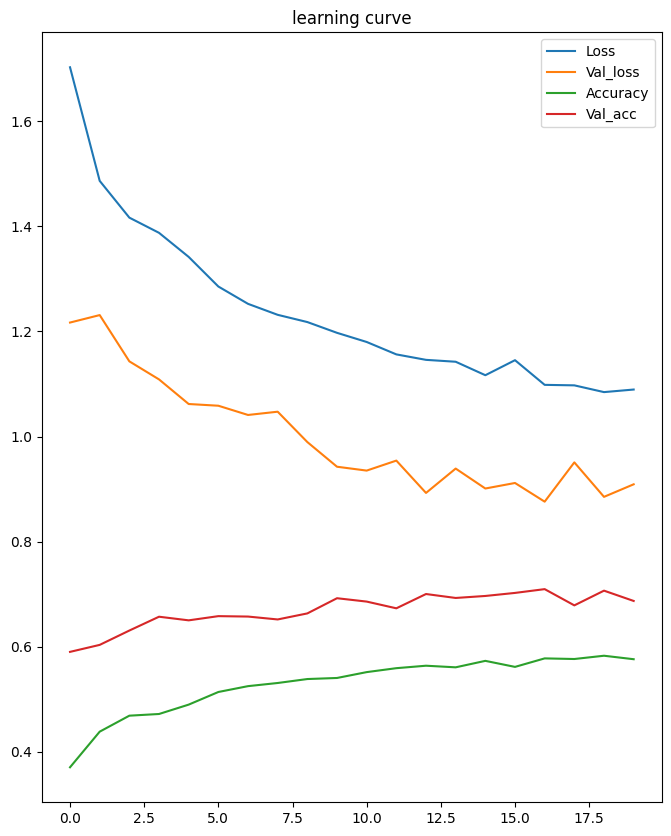

In [5]:
##set figsize
plt.figure(figsize = (8, 10))

##plot training curve
#plt.subplot(4, 2, 1)
plt.plot(history.history['loss'], label = 'Loss')
plt.plot(history.history['val_loss'], label = 'Val_loss')
plt.plot(history.history['accuracy'], label = 'Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Val_acc')
plt.title('learning curve')
plt.legend()

plt.show()

In [ ]:
#save model weights into disk
model.save('/content/drive/MyDrive/Segmentation Models/vgg16_model.h5')

In [ ]:
#save training history into disk
import pickle
with open('/content/drive/MyDrive/vgg16_trainhistDict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [ ]:
#loading training history from disk
history = pickle.load(open('/content/drive/MyDrive/vgg16_trainhistDict', 'rb'))

In [ ]:
#load model
import tensorflow
loaded_model = tensorflow.keras.models.load_model('/content/drive/MyDrive/Segmentation Models/vgg16_model.h5')

In [ ]:
##labels list
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer','dog', 'frog',
          'horse', 'ship', 'truck']
## Create tf.data.Dataset objects
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)

evaluation = model.evaluate(test_dataset)
print(f"Test Accuracy: {evaluation[1]*100:.2f}%")

##resize X_test
x_test_resized = tf.image.resize(x_test, [224, 224])
x_test_resized = x_test_resized/255.0

##prediction on test data
y_pred = model.predict(x_test_resized)
y_pred = np.argmax(y_pred, axis=1)

##confusion matrix
cm = confusion_matrix(y_test_org, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

##plot the cm
fig, ax = plt.subplots(figsize = (10, 10))
disp = disp.plot(xticks_rotation = 'vertical', ax = ax, cmap = 'summer')
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 38s 122ms/step - accuracy: 0.6832 - loss: 0.9174
Test Accuracy: 68.34%


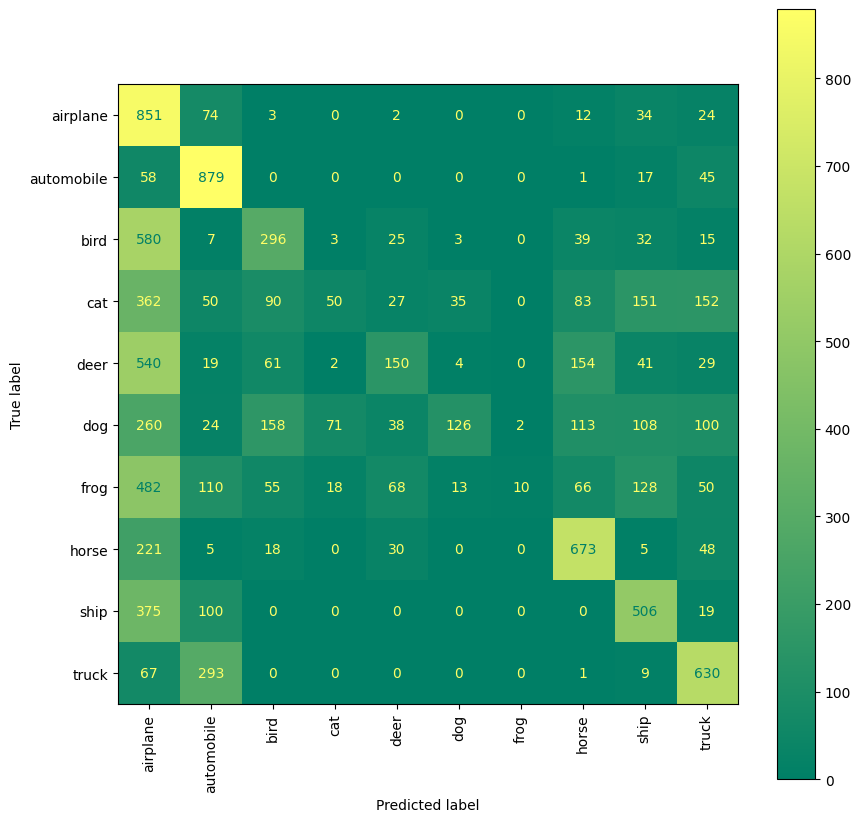

In [10]:
##labels list
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer','dog', 'frog',
          'horse', 'ship', 'truck']

##confusion matrix
cm = confusion_matrix(y_test_org, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

##plot the cm
fig, ax = plt.subplots(figsize = (10, 10))
disp = disp.plot(xticks_rotation = 'vertical', ax = ax, cmap = 'summer')
plt.show()

In [ ]:
##classification report
print(classification_report(y_test, y_pred))